In [2]:
import renom as rm
from renom.utility.distributor import ImageClassificationDistributor
from renom.utility.distributor.imageloader import ImageLoader
from renom.utility.image import *
from renom.optimizer import Sgd, Adam
from renom.cuda.cuda import set_cuda_active
import matplotlib.pyplot as plt
import numpy as np
import math
import os

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
set_cuda_active(False)

In [4]:
def load_for_classification(path):
    class_list = ["Motorbikes", "airplanes"] # データセット内で大文字と小文字が混在しているため、先頭不一致
    onehot_vectors = []
    for i in range(len(class_list)):
        temp = [0] * len(class_list) # [0, 0]
        temp[i] = 1
        onehot_vectors.append(temp) # Motorbikes: [1, 0], airplanes: [0, 1]
    X_list = [] # データセットの画像のパスを格納する配列
    y_list = [] # ラベル（one-hot ベクトル）
    for classname in class_list:
        imglist = os.listdir(path + classname) # class_list の要素と一致するディレクトリ内の画像をリストで取得
        for filename in imglist:
            filepath = path + classname + "/" + filename
            X_list.append(filepath)
            onehot = onehot_vectors[class_list.index(classname)]
            y_list.append(onehot) # 取得した画像データにラベル(one-hot ベクトル)付けをする

    return X_list, y_list, class_list

In [5]:
path = "101_ObjectCategories/"
X_list, Y_list, class_list = load_for_classification(path)

In [6]:
x_size=32
y_size=32
channel=3

# Load data
X_tmp = np.empty((0,x_size*y_size*channel), int) # 0 x 3072(=32*32*3) の配列を生成（各要素の値が初期化されていないため、生成速度が早い）
Y_tmp = []
for i in range(len(X_list)):
    img = Image.open(X_list[i]).convert('RGB') # Python Imaging Library #open()
    img = img.resize((x_size,y_size)) # 画像サイズを変換
    img = np.asarray(img) # Image クラスのインスタンスを配列に変換
    img = img / 255. # 各ピクセルの値を0-1の範囲に収まるようにスケーリング
    img = np.array([list(img.flatten())]) # 1次元配列に変換
    X_tmp = np.append(X_tmp, img, axis=0) # 追加する配列の形が一致していることを確認しつつ、配列に追加
Y_tmp = np.array(Y_list)

# Split images
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tmp, Y_tmp, test_size=test_size,random_state=16)

# Reshape images and binalize
X_train = X_train.reshape(-1, x_size, y_size, channel) # 行列の形を変える
X_train = X_train.transpose(0,3,1,2)
labels_train = LabelBinarizer().fit_transform(y_train).astype(np.float32)

X_test = X_test.reshape(-1, x_size, y_size, channel)
X_test = X_test.transpose(0,3,1,2)
labels_test = LabelBinarizer().fit_transform(y_test).astype(np.float32)

In [7]:
sequential = rm.Sequential([
        rm.Conv2d(channel=32), # カーネルを32枚使用する
        rm.Relu(),
        rm.MaxPool2d(filter=2, stride=2), # プーリング層
        rm.Dropout(dropout_ratio=0.25), # Dropout で過学習を抑制
        rm.Flatten(),
        rm.Dense(256),
        rm.Relu(),
        rm.Dropout(dropout_ratio=0.5),
        rm.Dense(2),
    ])

In [8]:
# Choose neural network.
network = sequential # 変数名を変更しただけ？
# Choose optimizer
optimizer = Adam()

In [9]:
N = len(X_train)

# Hyper parameters
batch = 100
epoch = 10

learning_curve = []
test_learning_curve = []

for i in range(epoch):
    perm = np.random.permutation(N)
    loss = 0
    for j in range(0, N // batch):
        train_batch = X_train[perm[j * batch:(j + 1) * batch]]
        responce_batch =labels_train[perm[j * batch:(j + 1) * batch]]

        # Loss function
        network.set_models(inference=False) # inference: 推論モード=OFF
        with network.train():
            l = rm.softmax_cross_entropy(network(train_batch), responce_batch)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)
        loss += l.as_ndarray()

    train_loss = loss / (N // batch)

    # Validation
    test_loss = 0
    M = len(X_test)
    network.set_models(inference=True)
    for j in range(M//batch):
        test_batch = X_test[j * batch:(j + 1) * batch]
        test_label_batch = labels_test[j * batch:(j + 1) * batch]
        #print(test_label_batch)
        prediction = network(test_batch)
        test_loss += rm.softmax_cross_entropy(prediction, test_label_batch).as_ndarray()
    test_loss /= (j+1)

    test_learning_curve.append(test_loss)
    learning_curve.append(train_loss)
    print("epoch %03d train_loss:%f test_loss:%f"%(i, train_loss, test_loss))

epoch 000 train_loss:0.921121 test_loss:0.456057
epoch 001 train_loss:0.336979 test_loss:0.234498
epoch 002 train_loss:0.184586 test_loss:0.133480
epoch 003 train_loss:0.104271 test_loss:0.075367
epoch 004 train_loss:0.072464 test_loss:0.053675
epoch 005 train_loss:0.052552 test_loss:0.034872
epoch 006 train_loss:0.041063 test_loss:0.025577
epoch 007 train_loss:0.031093 test_loss:0.018826
epoch 008 train_loss:0.029481 test_loss:0.017746
epoch 009 train_loss:0.023207 test_loss:0.013080


[[150   0]
 [  0 170]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       150
          1       1.00      1.00      1.00       170

avg / total       1.00      1.00      1.00       320



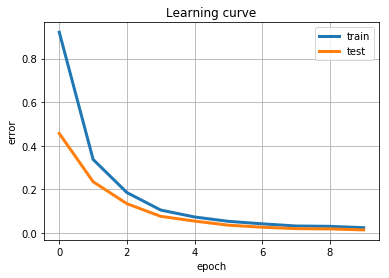

In [10]:
network.set_models(inference=True)
predictions = np.argmax(network(X_test).as_ndarray(), axis=1)

# Confusion matrix and classification report.
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, predictions))
print(classification_report(test_seikai_label, predictions))

# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_learning_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()

In [15]:
diff = test_seikai_label.reshape(-1,) - predictions
print (diff)
diff_num = np.count_nonzero(diff)
diff_list = np.where(diff != 0)

for i in range(diff_num):
    print (diff_num)
    plt.imshow(X_test[diff_list][i][0], 'gray')
    plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
